In [141]:
import h5py
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import io
import torch
import torch.nn as nn
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.optim as optim
import wandb
from dotenv import load_dotenv
import os
from sklearn.metrics import accuracy_score, f1_score,  roc_curve, auc
import tensorflow as tf
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from numpy.random import randn

In [ ]:
load_dotenv()
wandb_api_key = os.getenv('WANDB_API_KEY')
wandb_entity = os.getenv('WANDB_ENTITY')
wandb.login(key=wandb_api_key)
wandb.init(project="skin-cancer-detection", entity=wandb_entity, name="mobilenetv2")

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [144]:
train_meta_path = 'train-metadata.csv'
test_meta_path = 'test-metadata.csv'
train_img_path = 'train-image.hdf5'
test_img_path = 'test-image.hdf5'
check_point_path = 'checkpoints'
model_path = 'models'

In [ ]:
train_metadata = pd.read_csv(train_meta_path)
# train_metadata.info()

In [145]:
positives = train_metadata[train_metadata['target'] == 1]  # All malignant cases
negatives = train_metadata[train_metadata['target'] == 0]  # All benign cases

pos_patient = set(positives['patient_id'])
neg_patient = set(negatives['patient_id'])
print(f"Number of positive patients: {len(pos_patient)}")
print(f"Number of negative patients: {len(neg_patient)}")

# Find overlap between positive and negative patient IDs
overlap_patient_ids = pos_patient.intersection(neg_patient)

# Check if there is any overlap
if overlap_patient_ids:
    print(f"Overlap found! {len(overlap_patient_ids)} patient(s) have records in both positive and negative cases.")
    print("Overlapping patient IDs:", overlap_patient_ids)
else:
    print("No overlap between positive and negative patient IDs.")


Number of positive patients: 259
Number of negative patients: 1041
Overlap found! 258 patient(s) have records in both positive and negative cases.
Overlapping patient IDs: {'IP_3912094', 'IP_7494122', 'IP_9103159', 'IP_5967999', 'IP_1509264', 'IP_2068150', 'IP_1474479', 'IP_5147120', 'IP_8849896', 'IP_8372519', 'IP_8567950', 'IP_9181133', 'IP_1093030', 'IP_8292126', 'IP_5044083', 'IP_1092190', 'IP_3921915', 'IP_2612113', 'IP_3537591', 'IP_2224950', 'IP_3220951', 'IP_0264059', 'IP_7541961', 'IP_7977194', 'IP_8721252', 'IP_1016097', 'IP_4332092', 'IP_0889220', 'IP_2491677', 'IP_7497380', 'IP_6413837', 'IP_4076839', 'IP_2945977', 'IP_8494850', 'IP_6141958', 'IP_8683966', 'IP_3212820', 'IP_3923321', 'IP_3844290', 'IP_7259384', 'IP_1075722', 'IP_3905195', 'IP_9978624', 'IP_3249371', 'IP_1741190', 'IP_8666903', 'IP_5611762', 'IP_4540594', 'IP_6391213', 'IP_7249064', 'IP_0325406', 'IP_2725676', 'IP_6724798', 'IP_0277335', 'IP_5799983', 'IP_2608498', 'IP_7215455', 'IP_5426188', 'IP_3720977', '

In [146]:
class CFG:
    lr = 0.001  
    image_size = (224, 224) # Image size for MobileNetV2
    model_name = "mobilenetv2"  
    seed = 42  
    neg_sample = 0.01  # Downsample negative class
    pos_sample = 5.0  # Upsample positive class
    epochs = 10  
    batch_size = 64 
    class_names = ['target']
    num_classes = 1


In [147]:
print("Class Distribution Before Sampling (%):")
print(train_metadata.target.value_counts(normalize=True) * 100)

# Sampling
positive_df = train_metadata.query("target == 1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)  # Upsample positives
negative_df = train_metadata.query("target == 0").sample(frac=CFG.neg_sample, random_state=CFG.seed)  # Downsample negatives
df_sampled = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=CFG.seed)

print("\nClass Distribution After Sampling (%):")
print(df_sampled.target.value_counts(normalize=True) * 100)



Class Distribution Before Sampling (%):
target
0    99.902009
1     0.097991
Name: proportion, dtype: float64

Class Distribution After Sampling (%):
target
0    67.09645
1    32.90355
Name: proportion, dtype: float64


In [148]:
from sklearn.model_selection import StratifiedGroupKFold

df = df_sampled.reset_index(drop=True) 

# Initialize the fold column with -1
df["fold"] = -1

# Stratified Group K-Fold split ensuring stratification on 'target' and grouping by 'patient_id'
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Split and assign fold numbers
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use fold 0 for validation, and the rest for training
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")

print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


In [149]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df_sampled['target']), y=df_sampled['target'])
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


In [150]:
class HDF5Dataset_MobileV2(Dataset):
    def __init__(self, balanced_data, img_hdf5_path,  transform=None):
        self.metadata = balanced_data
        self.img_hdf5_path = img_hdf5_path
        self.transform = transform
        self.hdf5_file = h5py.File(img_hdf5_path, 'r')
        self.isic_ids = self.metadata['isic_id'].tolist()
        self.targets = self.metadata['target'].tolist()

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        isic_id = self.isic_ids[idx]
        img_bytes = self.hdf5_file[isic_id][()]
        img = Image.open(io.BytesIO(img_bytes))  

        if self.transform:
            img = self.transform(img)

        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        return img, target

    def __del__(self):
        self.hdf5_file.close()


In [151]:

train_transform = transforms.Compose([
    transforms.Resize(CFG.image_size), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # Convert to PyTorch tensor (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as expected by MobileNetV2
])
val_transform = transforms.Compose([
    transforms.Resize(CFG.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [152]:
train_dataset = HDF5Dataset_MobileV2(balanced_data=training_df, img_hdf5_path=train_img_path, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_dataset = HDF5Dataset_MobileV2(balanced_data=validation_df, img_hdf5_path=train_img_path, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)


In [ ]:
model = models.mobilenet_v2(pretrained=True)
# model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False 


model.classifier = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.classifier[1].in_features, CFG.num_classes)  
) 
# model.fc = nn.Sequential(
#     nn.Dropout(0.1),
#     nn.Linear(model.fc.in_features, CFG.num_classes)
# )
for param in model.fc.parameters():
    param.requires_grad = True  


# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [163]:
pos_weight = torch.tensor(class_weights[1], dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss()  # Binary classification, so we use BCE with logits
# optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
optimizer = optim.Adam(model.classifier.parameters(), lr=CFG.lr)
wandb.watch(model)

[]

In [155]:

def calculate_pAUC(solution, submission, min_tpr=0.80):
    v_gt = abs(np.asarray(solution)-1)
    v_pred = -1.0*np.asarray(submission)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

def calculate_metrics(y_true, y_pred):
    y_pred_label = (y_pred > 0.5).astype(int)  
    accuracy = accuracy_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label, average='macro')
    p_auc = calculate_pAUC(y_true, y_pred, min_tpr=0.80)
    
    return accuracy,  f1, p_auc

In [156]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_val_loss = 0.0
        y_true_train, y_pred_train = [], []
       
        # Training phase
        for image, labels in train_loader:
            image, labels = image.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(image)
            outputs = outputs.squeeze(1)  # Flatten the output for BCEWithLogitsLoss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(outputs.detach().cpu().numpy())
        train_accuracy, train_f1, train_pauc = calculate_metrics(np.array(y_true_train), np.array(y_pred_train))
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for image, labels in val_loader:
                image, labels = image.to(device), labels.to(device)

                outputs = model(image)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        val_accuracy,  val_f1, val_pauc = calculate_metrics(np.array(y_true), np.array(y_pred))
       
        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)

        y_pred_val_label = (np.array(y_pred) > 0.5).astype(int)
       
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "train_macro_f1": train_f1,
            "train_pAUC": train_pauc,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "val_macro_f1": val_f1,
            "val_pAUC": val_pauc,
            "confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred_val_label, class_names=["Negative", "Positive"])
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Train Acc: {train_accuracy:.4f},  Train F1: {train_f1:.4f}, Train pAUC: {train_pauc:.4f}")
        print(f"Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Val pAUC: {val_pauc:.4f}")

 


In [ ]:

train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=CFG.epochs)
wandb.finish()

GAN model

In [65]:
class HDF5Dataset(Dataset):
    def __init__(self, balanced_metadata_path, img_hdf5_path, transform=None):
        self.metadata = pd.read_csv(balanced_metadata_path)
        self.img_hdf5_path = img_hdf5_path
        self.transform = transform
        self.hdf5_file = h5py.File(img_hdf5_path, 'r')
        self.isic_ids = self.metadata['isic_id'].tolist()
        self.targets = self.metadata['target'].tolist()

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        isic_id = self.isic_ids[idx]
        img_bytes = self.hdf5_file[isic_id][()]
        img = Image.open(io.BytesIO(img_bytes))  # Convert to PIL Image here
        
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        img = img.permute(1, 2, 0)
        img = np.array(img, dtype=np.float32)
        target = np.array(target, dtype=np.float32)

        return img, target

    def __del__(self):
        self.hdf5_file.close()



In [66]:

# Define transformations: resize to 64x64 and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Initialize the dataset with the balanced metadata
balanced_dataset = HDF5Dataset(
    balanced_metadata_path='balanced-metadata.csv',
    img_hdf5_path='train-image.hdf5',
    transform=transform
)

In [67]:
img, target = balanced_dataset[0]

print(img)
print(target)

[[[ 0.10588241 -0.11372548 -0.30196077]
  [ 0.09019613 -0.12941176 -0.31764704]
  [ 0.082353   -0.1372549  -0.32549018]
  ...
  [ 0.15294123 -0.05882353 -0.27058822]
  [ 0.15294123 -0.05882353 -0.27058822]
  [ 0.15294123 -0.05882353 -0.27058822]]

 [[ 0.11372554 -0.10588235 -0.29411763]
  [ 0.10588241 -0.11372548 -0.30196077]
  [ 0.09803927 -0.12156862 -0.3098039 ]
  ...
  [ 0.19215691 -0.01960784 -0.23137254]
  [ 0.19215691 -0.01960784 -0.23137254]
  [ 0.19215691 -0.01960784 -0.23137254]]

 [[ 0.09803927 -0.12156862 -0.3098039 ]
  [ 0.09019613 -0.12941176 -0.31764704]
  [ 0.09019613 -0.12941176 -0.31764704]
  ...
  [ 0.21568632  0.00392163 -0.20784312]
  [ 0.21568632  0.00392163 -0.20784312]
  [ 0.21568632  0.00392163 -0.20784312]]

 ...

 [[ 0.02745104 -0.1607843  -0.3490196 ]
  [-0.01960784 -0.20784312 -0.3960784 ]
  [-0.03529412 -0.2235294  -0.41176468]
  ...
  [ 0.0196079  -0.16862744 -0.372549  ]
  [ 0.04313731 -0.14509803 -0.3490196 ]
  [ 0.06666672 -0.12156862 -0.32549018]]

 [

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def define_discriminator(in_shape=(128, 128, 3)):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Test the discriminator
discriminator = define_discriminator()
discriminator.summary()


In [ ]:
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8  # 8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  # 8x8x128 feature maps
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(Conv2D(3, (8, 8), activation='tanh', padding='same'))
    return model

# Test the generator
latent_dim = 100
generator = define_generator(latent_dim)
generator.summary()


In [49]:
def define_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # Compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Test the GAN model
gan_model = define_gan(generator, discriminator)
gan_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ ?                      │     1,901,059 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ ?                      │       454,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,355,588 (8.99 MB)

 Trainable params: 1,901,059 (7.25 MB)

 Non-trainable params: 454,529 (1.73 MB)

In [86]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, len(dataset), n_samples)
	# select the random images and assign it to X
	X = []
	y = []
	for i in ix:
		img, label = dataset[i]
		X.append(img)
		y.append(label)
	X = np.array(X)
	y = np.array(y)
	# generate class labels and assign to y
	y = ones((n_samples, 1)) *0.9 #Label=1 indicating they are real
	return X, y

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# Generate fake samples (no changes needed for this part)
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y_fake = np.zeros((n_samples, 1))  # Label for fake images (0 for fake)
    return X, y_fake


In [87]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2, n_batch=64):
	bat_per_epo = int(len(dataset) / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs and bacthes.
	for epoch in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			for _ in range(2):
				g_loss = gan_model.train_on_batch(X_gan, y_gan)
			

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(epoch+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss[0]))
	# save the generator model
	g_model.save('cifar_generator_epochs.keras')

     

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

# print(dataset)
# train model
train(generator, discriminator, gan_model, balanced_dataset, latent_dim)


c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\lilil\AppData\Local\Programs\Python\P

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
Epoch>1, Batch 1/37, d1=0.689, d2=0.691 g=0.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
Epoch>1, Batch 2/37, d1=0.690, d2=0.691 g=0.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Epoch>1, Batch 3/37, d1=0.691, d2=0.691 g=0.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Epoch>1, Batch 4/37, d1=0.690, d2=0.692 g=0.692
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
Epoch>1, Batch 5/37, d1=0.691, d2=0.693 g=0.693
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch>1, Batch 6/37, d1=0.693, d2=0.697 g=0.697
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch>1, Batch 7/37, d1=0.696, d2=0.703 g=0.703
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch>1, Batch 8/37, d1=0.702, d2=0.711 g=0.711
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch>1, Batch 9/37, d1=0.710, d2=0.720 g=0.720
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch>1, Batch 10/37, d1=0.718, d2=0.729 g=0.729
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch>1, Batch 11/37, d1=0.727, d2=0.737 g=0.737
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
Epoch>1, Batch 12/37

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


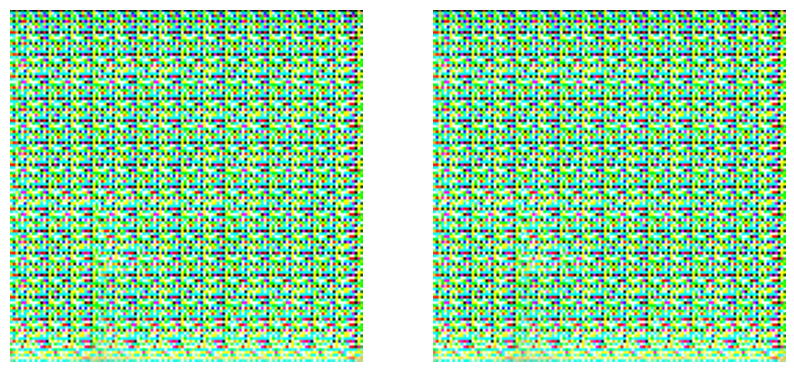

In [88]:
# Function to plot generated images
def plot_generated_images(images, n_samples):
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

# Generate new images
n_samples = 2
latent_points = generate_latent_points(latent_dim, n_samples)
generated_images = generator.predict(latent_points)

# Rescale images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Visualize generated images
plot_generated_images(generated_images, n_samples)

In [99]:
import os
import pandas as pd
import h5py
from PIL import Image
import io
import torch
import numpy as np



class HDF5Dataset(Dataset):
    def __init__(self, balanced_metadata_path, img_hdf5_path, transform=None):
        self.metadata = pd.read_csv(balanced_metadata_path)
        self.img_hdf5_path = img_hdf5_path
        self.transform = transform
        self.hdf5_file = h5py.File(img_hdf5_path, 'r')
        self.isic_ids = self.metadata['isic_id'].tolist()
        self.targets = self.metadata['target'].tolist()

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        isic_id = self.isic_ids[idx]
        img_bytes = self.hdf5_file[isic_id][()]
        img = Image.open(io.BytesIO(img_bytes))  # Convert to PIL Image here
        img = img.resize((256,256))
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(np.array(img), dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        # img = img.permute(0, 1, 2)
        img = np.array(img, dtype=np.float32)
        target = np.array(target, dtype=np.float32)

        return img, target

    def __del__(self):
        self.hdf5_file.close()


# Save dataset as image files
def save_images_from_hdf5(dataset, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i in range(len(dataset)):
        img, target = dataset[i]
        print(img.shape)
        img = (img * 255).astype(np.uint8)  # Convert to 8-bit format for saving
        img_pil = Image.fromarray(img)
        
        # Save image to file
        img_pil.save(os.path.join(save_dir, f"{i}_{int(target)}.jpg"))

# Usage example:
# Assuming you have the dataset paths
balanced_metadata_path = 'balanced-metadata.csv'
img_hdf5_path = 'train-image.hdf5'

# Initialize your dataset (you can also add transforms if needed)
dataset = HDF5Dataset(balanced_metadata_path, img_hdf5_path)

# Directory to save images
save_dir = './dataset_images'

# Save the images from the dataset
save_images_from_hdf5(dataset, save_dir)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 